In [2]:
from pylab import *
import matplotlib.pyplot as plt
import pyAgrum as gum
import pandas as pd
import pyAgrum.lib.notebook as gnb
import utils

### Setup bayesian network

In [3]:
bn = gum.BayesNet("WaterSprinkler")
c=bn.add(gum.LabelizedVariable('cloudy', 'Cloudy?', 2))
s=bn.add(gum.LabelizedVariable('sprinkler', 'Sprinkler?', 2))
r=bn.add(gum.LabelizedVariable('rain', 'Rain?', 2))
w=bn.add(gum.LabelizedVariable('wet', 'Wet Grass?', 2))
bn.addArc(c,s)
bn.addArc(c, r)
bn.addArc(r, w)
bn.addArc(s, w)
display(bn)

(pyAgrum.BayesNet<double>@0x131a64000) BN{nodes: 4, arcs: 4, domainSize: 16, dim: 9, mem: 144o}

### Specify Conditional Probability Tables

In [4]:
# The conditional probability tables can be defined manually like so

bn.cpt(c)[:] = [0.25,0.75]

bn.cpt(s)[{'cloudy':0}] = [0.1,0.9]
bn.cpt(s)[{'cloudy':1}] = [0.2,0.8]

bn.cpt(r)[{'cloudy':0}] = [1,0]
bn.cpt(r)[{'cloudy':1}] = [0.4,0.6]

bn.cpt('wet')[{'rain': 0, 'sprinkler': 0}] = [1, 0]
bn.cpt('wet')[{'rain': 1, 'sprinkler': 0}] = [0.01, 0.99]
bn.cpt('wet')[{'rain': 1, 'sprinkler': 1}] = [0, 1]
bn.cpt('wet')[{'rain': 0, 'sprinkler': 1}] = [0.01, 0.99]

### Learning CPTs from data

In [5]:
# The CPTs can also be learned from data

df = utils.GetSyntheticData()
bn = utils.LearnParameters(bn,df)

In [6]:
#Display all probability tables
for n in bn.names():
    display(bn.cpt(n))

(pyAgrum.Potential<double>@0x105b6fab0) 
      ||  sprinkler        |
cloudy||0        |1        |
------||---------|---------|
0     || 0.5000  | 0.5000  |
1     || 0.2000  | 0.8000  |

(pyAgrum.Potential<double>@0x105b5fe60) 
  cloudy           |
0        |1        |
---------|---------|
 0.6154  | 0.3846  |

(pyAgrum.Potential<double>@0x105b7f2c0) 
             ||  wet              |
rain  |sprink||0        |1        |
------|------||---------|---------|
0     |0     || 0.8000  | 0.2000  |
1     |0     || 0.2500  | 0.7500  |
0     |1     || 0.5000  | 0.5000  |
1     |1     || 0.0000  | 1.0000  |

(pyAgrum.Potential<double>@0x105b72d10) 
      ||  rain             |
cloudy||0        |1        |
------||---------|---------|
0     || 0.8750  | 0.1250  |
1     || 0.4000  | 0.6000  |

### Inference

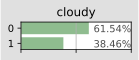

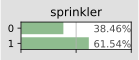

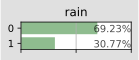

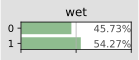

In [7]:
# Inference in bayseian networks is the proces of updating our belief in the state of the variables given the known state (evidence) of other variables.

i = gum.LazyPropagation(bn) # object for doing inference
i.makeInference() # we first do inference without any evidence. I.e. without assuming any knowledge of the variables in the network

#This helps us answer questions like:

# How likely is it to be cloydy? (which is the same as the prior probability above since the 'clody' variable has no parents influencing it)
gnb.showProba(i.posterior(c))


# How likely is it that the sprinkler was on?
gnb.showProba(i.posterior(s))

# How likely is it that it has rained ?
gnb.showProba(i.posterior(r))

# How likely is it that the grass is wet?
gnb.showProba(i.posterior(w))


### Inference using evidence

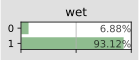

In [8]:
i = gum.LazyPropagation(bn) # object for doing inference
# Knowing the state of certain variables is called evidence. Using this we can answer questions like: 

# Given that we know the sprinkler was on, what is the likelihood that the grass is wet
i.setEvidence({r:[0,1]})
gnb.showProba(i.posterior(w))

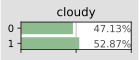

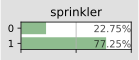

In [9]:
# Given that we know the grass is wet, what is the probability that it was cloudy or that the sprinkler was on?
# Compared to when we didn't know the grass was wet, our belief in that it was either cloudy or the sprinkler was on is now increased.
i.setEvidence({w:[0,1]})
gnb.showProba(i.posterior(c))
gnb.showProba(i.posterior(s))

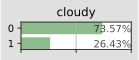

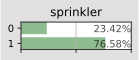

In [10]:
# Given that we know the grass is wet but that it also did not rain, what is the probability that it was cloudy or that the sprinkler was on?
# We see that this increases our belief in the sprinkler being on and decreases our belief in the sky being cloudy.
# This is called the 'explaining away' effect in bayesian networks.
i.setEvidence({w:[0,1], r:[1,0]})
gnb.showProba(i.posterior(c))
gnb.showProba(i.posterior(s))